In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
detected = pd.read_csv("../data/hfo_detection_results.csv")
demog = pd.read_csv('../data/ds004100/participants.tsv', sep='\t')

detected['subject'] = detected['file'].str.extract(r'(sub-HUP\d+)', expand=False)

In [9]:
df = detected.merge(
    demog,
    left_on="subject",
    right_on="participant_id",
    how="left"
)

df.head()

,Unnamed: 0,file,channel,n_hfos,duration_samples,duration_sec,subject,participant_id,age,sex,hand,outcome,engel,therapy,implant,target,lesion_status,age_onset
0,0,sub-HUP060_ses-presurgery_task-ictal_acq-seeg_...,LAF1,2,83,0.166,sub-HUP060,sub-HUP060,42.0,F,R,F,3A,ABLATION,SEEG,FRONTAL,NaN,12.0
1,1,sub-HUP060_ses-presurgery_task-ictal_acq-seeg_...,LAF2,0,0,0.000,sub-HUP060,sub-HUP060,42.0,F,R,F,3A,ABLATION,SEEG,FRONTAL,NaN,12.0
2,2,sub-HUP060_ses-presurgery_task-ictal_acq-seeg_...,LAF3,2,62,0.124,sub-HUP060,sub-HUP060,42.0,F,R,F,3A,ABLATION,SEEG,FRONTAL,NaN,12.0
3,3,sub-HUP060_ses-presurgery_task-ictal_acq-seeg_...,LAF4,2,51,0.102,sub-HUP060,sub-HUP060,42.0,F,R,F,3A,ABLATION,SEEG,FRONTAL,NaN,12.0
4,4,sub-HUP060_ses-presurgery_task-ictal_acq-seeg_...,RA2,0,0,0.000,sub-HUP060,sub-HUP060,42.0,F,R,F,3A,ABLATION,SEEG,FRONTAL,NaN,12.0


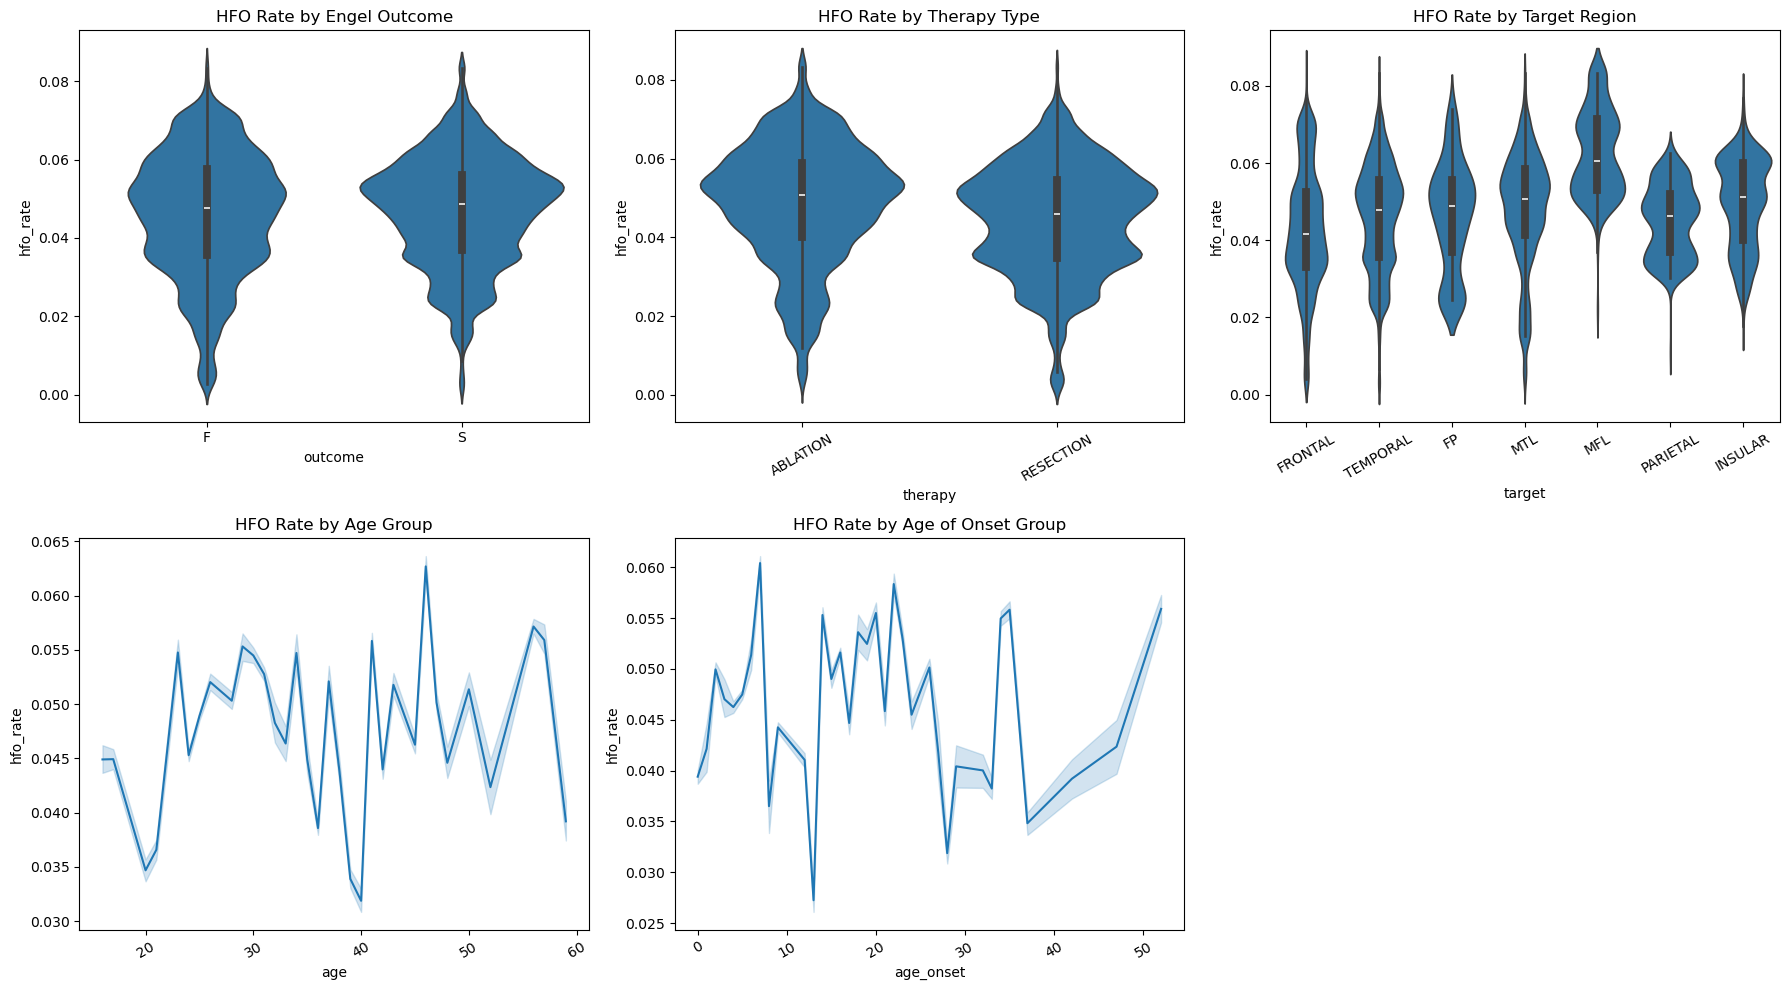

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
df['hfo_rate'] = df['n_hfos']/df['duration_samples']

sns.violinplot(data=df, x='outcome',     y='hfo_rate', ax=axes[0])
axes[0].set_title('HFO Rate by Engel Outcome')

sns.violinplot(data=df, x='therapy',     y='hfo_rate', ax=axes[1])
axes[1].set_title('HFO Rate by Therapy Type')
axes[1].tick_params(axis='x', rotation=30)

sns.violinplot(data=df, x='target',      y='hfo_rate', ax=axes[2])
axes[2].set_title('HFO Rate by Target Region')
axes[2].tick_params(axis='x', rotation=30)

sns.lineplot(data=df, x='age',     y='hfo_rate', ax=axes[3])
axes[3].set_title('HFO Rate by Age Group')
axes[3].tick_params(axis='x', rotation=30)

sns.lineplot(data=df, x='age_onset',   y='hfo_rate', ax=axes[4])
axes[4].set_title('HFO Rate by Age of Onset Group')
axes[4].tick_params(axis='x', rotation=30)

axes[5].axis('off')

plt.tight_layout()
plt.show()

In [15]:
import statsmodels.formula.api as smf

# univariate
m1 = smf.ols("hfo_rate ~ age", data=df).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:               hfo_rate   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     91.50
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           1.23e-21
Time:                        16:08:20   Log-Likelihood:                 63669.
No. Observations:               22648   AIC:                        -1.273e+05
Df Residuals:                   22646   BIC:                        -1.273e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0434      0.000    126.536      0.0

In [16]:
#log transform

smf.ols("np.log(hfo_rate+1e-3) ~ age", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(hfo_rate + 1e-3)   R-squared:                       0.001
Model:                                 OLS   Adj. R-squared:                  0.001
Method:                      Least Squares   F-statistic:                     30.59
Date:                     Thu, 31 Jul 2025   Prob (F-statistic):           3.22e-08
Time:                             16:08:22   Log-Likelihood:                -11687.
No. Observations:                    22648   AIC:                         2.338e+04
Df Residuals:                        22646   BIC:                         2.340e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1611      0.010   -330.639      0.000      -3.180      -3.142
age            0.0015      0.000      5.531      0.000       0.001       0.002
==============================================================================
Omnibus:                    10797.317   Durbin-Watson:                   0.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78464.518
Skew:                          -2.177   Prob(JB):                         0.00
Kurtosis:                      11.012   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OOOPs

In [ ]:
import statsmodels.api as sm

# 1) Pick only the columns you need & copy
df_model = df[['n_hfos','duration_s','age']].copy()

# 2) Replace zeros in duration (if any) with NaN so they’ll be dropped
df_model.loc[df_model.duration_s == 0, 'duration_s'] = np.nan

# 3) Convert any ±inf to NaN
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4) Drop all rows with any NaN
df_model = df_model.dropna()
print(f"Kept {len(df_model)} out of {len(df)} runs for modeling")

# 5) Build the GLM
y      = df_model['n_hfos']
X      = sm.add_constant(df_model['age'])
offset = np.log(df_model['duration_s'])

poisson = sm.GLM(
    y,
    X,
    family=sm.families.Poisson(),
    offset=offset,
    missing='drop'   # double‐ensure missing data are removed
).fit()

print(poisson.summary())

KeyError: "['duration_seconds'] not in index"

In [13]:
# prepare data as before, with no missing or zero‐duration rows
y      = df_model['n_hfos']
X      = sm.add_constant(df_model['age'])
offset = np.log(df_model['duration_s'])

nb = sm.GLM(
    y,
    X,
    family=sm.families.NegativeBinomial(alpha=1.0),
    offset=offset
).fit()

print(nb.summary())
print("Dispersion (Pearson χ²/df):", nb.pearson_chi2/nb.df_resid)

NameError: name 'df_model' is not defined